In [104]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets

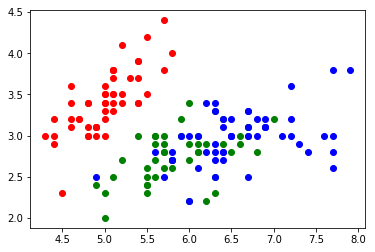

In [69]:
# load data
a = datasets.load_iris()
X = a.data
y = a.target
cstr = {0:'r', 1:'g', 2:'b'}
for i in range(3):
    plt.plot(X[y==i, 0], X[y==i, 1], cstr[i]+'o')

ix = 0; iy = 1; nx = 40; ny = 30
xx, yy = np.meshgrid( np.linspace(min(X[:,ix]), max(X[:,ix]), nx), \
            np.linspace(min(X[:,iy]), max(X[:,iy]), ny) )
Xgrid = np.array([xx.ravel(), yy.ravel()]).T

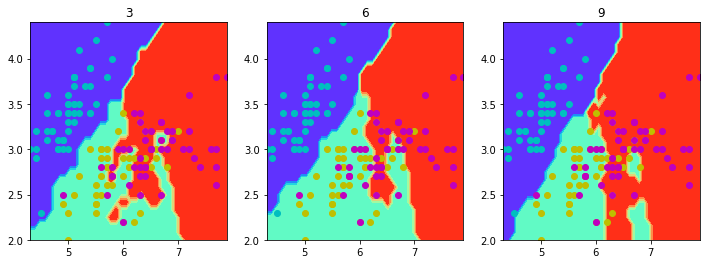

In [74]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

plt.figure(figsize=(12, 4))
ks = [3,6,9]
for i in range(len(ks)):
    plt.subplot(1, 3, i+1)
    k = ks[i]
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X[:,0:2], y)
    ygrid = clf.predict(Xgrid)
    ygrid = ygrid.reshape(xx.shape)

    plt.contourf(xx, yy, ygrid, cmap='rainbow')
    cstr = {0:'c', 1:'y', 2:'m'}
    for i in range(3):
        plt.plot(X[y==i, 0], X[y==i, 1], cstr[i]+'o')
    plt.title(k)
    

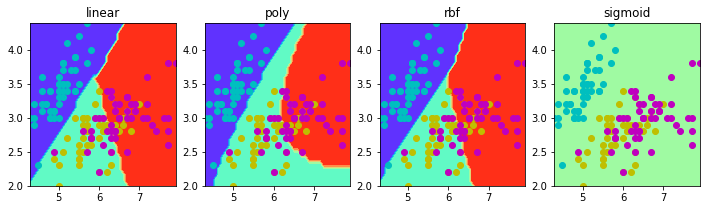

In [87]:
# SVM classification
from sklearn import svm

plt.figure(figsize=(12, 3))
ks = ['linear', 'poly',  'rbf', 'sigmoid']
for i in range(len(ks)):
    plt.subplot(1, 4, i+1)
    k = ks[i]
    clf = svm.SVC(kernel=k)
    clf.fit(X[:,0:2], y)
    ygrid = clf.predict(Xgrid)
    ygrid = ygrid.reshape(xx.shape)

    plt.contourf(xx, yy, ygrid, cmap='rainbow')
    cstr = {0:'c', 1:'y', 2:'m'}
    for i in range(3):
        plt.plot(X[y==i, 0], X[y==i, 1], cstr[i]+'o')
    plt.title(k)



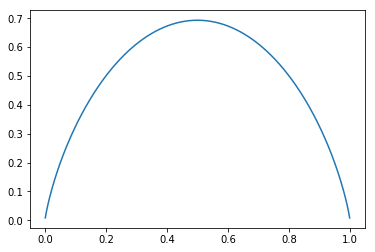

In [90]:
# entropy

x = np.linspace(0, 1, 1000)[1:-1]

h = - x*np.log(x) - (1-x) * np.log(1-x)

plt.plot(x, h)

myself: depth= 0 split_id= 0 split_value 5.5 impurity= 0.6666666666666667 range(0, 150)
myself: depth= 1 split_id= 1 split_value 2.9 impurity= 0.2374260355029585 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 57, 59, 60, 84, 93, 98, 106]
myself: depth= 2 split_id= 0 split_value 4.9 impurity= 0.44897959183673464 [41, 57, 59, 60, 93, 98, 106]
myself: depth= 3 split_id= 0 split_value 5.0 impurity= 0.2777777777777777 [57, 59, 60, 93, 98, 106]
myself: depth= 4 split_id= 1 split_value 2.5 impurity= 0.5 [57, 106]
myself: depth= 2 split_id= 0 split_value 5.4 impurity= 0.04345679012345682 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 84]
myself: depth= 3 split_id= 1 split_value 3.4 impurity= 0.2777777777777777 [5, 10, 16, 20, 31, 84]
myself: depth= 1 spl

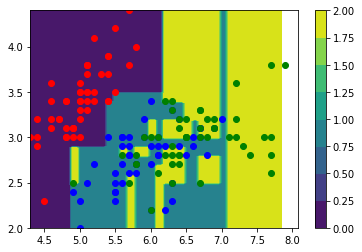

In [119]:
# Decision tree
import random

class Node:
    def __init__(self, split_id=None, split_value=None, \
                 sampleid = [], nsample=None, \
                 featureid = [], nfeature=None, \
                 depth=None, left=None, right=None, impurity=None, label=None):
        self.split_id = split_id
        self.split_value = split_value
        self.sampleid = sampleid
        self.nsample = nsample
        self.featureid = featureid
        self.nfeature = nfeature
        self.depth = depth
        self.left = left
        self.right = right
        self.impurity = impurity
        self.label = label
        return
    
    def cal_impurity(self, y, flag=2):
        # y should be a hot-encoding matrix
        # flag=1: cross-entropy
        # flag=2: Gini index        
        if self.nsample > 0:
            p = np.sum(y[self.sampleid, :], axis=0) / self.nsample
            self.label = np.argmax(p)
            if flag == 1:
                self.impurity = - np.sum( p[p>1e-12]*np.log(p[p>1e-12]) )
            if flag == 2:
                self.impurity = 1 - np.sum(p*p)
        return

    def cal_impurity_reduce(self):
        iafter = (self.left.nsample*self.left.impurity + self.right.nsample*self.right.impurity)/self.nsample
        return self.impurity - iafter

    def grouping(self, x):
        self.left.sampleid, self.right.sampleid = [], []
        for i in self.sampleid:
            if x[i, self.split_id] < self.split_value:
                self.left.sampleid.append(i)
            else:
                self.right.sampleid.append(i)
        self.left.nsample  = len(self.left.sampleid)
        self.right.nsample = len(self.right.sampleid)
        return

    pass

# recursively split the dataset
def split(x, y, node, maxdepth=999, minsample=1, feature_selection=0):
    # x: [sample, feature]
    # y: [sample, label]
    # feature_selection: 0 all features from parent nodes, 1 random selection sqrt(parent #feature)
    if node is not None:
        if (node.nsample <= minsample) or (node.nfeature < 1) or (node.depth >= maxdepth):
            return
        else:
            if node.impurity is None:  node.cal_impurity(y)
            if (node.impurity < 1e-12):  return

            if feature_selection == 0:
                node.left  = Node(featureid = node.featureid, nfeature = node.nfeature, depth=node.depth+1)
                node.right = Node(featureid = node.featureid, nfeature = node.nfeature, depth=node.depth+1)
            if feature_selection == 1:
                nfeature_child = int(np.ceil(np.sqrt(node.nfeature)))
                node.left  = Node(featureid = list(np.choice(node.featureid, size=nfeature_child), \
                                                   replace=False), \
                            nfeature = nfeature_child, depth = depth+1)
                node.right = Node(featureid = list(np.choice(node.featureid, size=nfeature_child), \
                                                   replace=False), \
                            nfeature = nfeature_child, depth = depth+1)
            max_change     = np.zeros([node.nfeature])
            max_splitvalue = max_change + np.nan
            for j in range(node.nfeature):
                node.split_id = node.featureid[j]
                for i in range(node.nsample):
                    node.split_value = x[node.sampleid[i], node.featureid[j]]
                    node.grouping(x)
                    if node.left.nsample > 0 and node.right.nsample > 0:
                        node.left.cal_impurity(y)
                        node.right.cal_impurity(y)
                        dp = node.cal_impurity_reduce()
                        #print(node.split_id, node.split_value, dp)
                        if dp > max_change[j]:
                            max_splitvalue[j] = x[node.sampleid[i], node.featureid[j]]
                            max_change[j] = dp
            jmax = np.argmax(max_change)
            node.split_id = node.featureid[jmax]
            node.split_value = max_splitvalue[jmax]
            node.grouping(x)
            node.left.cal_impurity(y)
            node.right.cal_impurity(y)

            print('myself: depth=', node.depth, 'split_id=', node.split_id, 'split_value', node.split_value, \
                  'impurity=', node.impurity, node.sampleid)
            #print('left: ', node.left.depth, node.left.impurity, node.left.sampleid, node.left.nsample, \
            #      node.left.featureid, node.left.nfeature)
            #print('right: ', node.right.depth , node.right.impurity, node.right.sampleid, \
            #      node.right.nsample, \
            #      node.right.featureid, node.right.nfeature)
            split(x, y, node.left, maxdepth=maxdepth, minsample=minsample, feature_selection=feature_selection)
            split(x, y, node.right, maxdepth=maxdepth, minsample=minsample, feature_selection=feature_selection)
    return

# recursively search in the tree to make prediction
def predict(x, root):
    if (root.left is None) and (root.right is None):
        return root.label
    else:
        if x[root.split_id] < root.split_value:
            return predict(x, root.left)
        else:
            return predict(x, root.right)


a = datasets.load_iris()
x = a.data
y = a.target
#imin = 85; imax = 109
imin = 0; imax = 150
ipart = range(imin, imax)

xpart = x[ipart, 0:2]
nsample, nfeature = xpart.shape[0], xpart.shape[1]
ypart = np.zeros([len(ipart), 3]).astype(int)
ypart[y[ipart]==0,0] = 1
ypart[y[ipart]==1,1] = 1
ypart[y[ipart]==2,2] = 1

root = Node(sampleid = range(nsample), nsample=nsample, featureid=range(nfeature), nfeature=nfeature, \
           depth=0)
#root.cal_impurity(ypart)
#print('original impurity = ', root.impurity)
split(xpart, ypart, root, maxdepth=10)

xx, yy = np.mgrid[min(xpart[:,0]):max(xpart[:,0]):0.05, min(xpart[:,1]):max(xpart[:,1]):0.02]
loc = np.array([xx.flatten(), yy.flatten()]).T
py = np.zeros([loc.shape[0]])
for k in range(loc.shape[0]):
    py[k] = predict(loc[k,:], root)

plt.contourf(xx, yy, py.reshape(xx.shape))
plt.colorbar()
    
cstr = {0:'r', 1:'b', 2:'g'}
for i in cstr:
    plt.plot(xpart[ypart[:,i]==1, 0], xpart[ypart[:,i]==1, 1], cstr[i]+'o')

#for i in range(nsample):
#    plt.text(xpart[i,0], xpart[i,1], format(i))
    


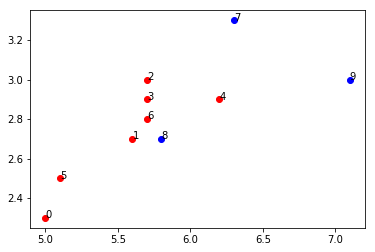

In [70]:
cstr = {0:'r', 1:'b'}
for i in cstr:
    plt.plot(xpart[ypart[:,i]==1, 0], xpart[ypart[:,i]==1, 1], cstr[i]+'o')

for i in range(nsample):
    plt.text(xpart[i,0], xpart[i,1], format(i))
